In [1]:
import matplotlib.pyplot as plt
from env import DATABASE_URI
from sqlalchemy import create_engine, select, and_
from sqlalchemy.orm import Session, scoped_session, sessionmaker
import models as md
from matplotlib import colormaps
import numpy as np
engine = create_engine(DATABASE_URI)
import pandas as pd

In [107]:
def query_sensor(run_id: int, sensor: str, cut_in=0) -> tuple[np.ndarray, np.ndarray]:
    with Session(engine) as session:
        query = select(md.Data).where(and_(md.Data.run_id == run_id, md.Data.sensor == sensor))
        data = session.execute(query.order_by(md.Data.id)).scalars().all()
        if not data:
            print("no data found!")
            return
        
        print(data[0].timestamp)
        t0 = data[cut_in].timestamp
        elapsed_time = lambda t: (t - t0).total_seconds() / (60*60) 

        times = [elapsed_time(row.timestamp) for row in data]
        temps = [row.celcius for row in data]

        print(f"last reading was at {data[-1].timestamp}")

        t0 = data[cut_in].timestamp
        elapsed_time = lambda t: (t - t0).total_seconds() / 60 

        times = [elapsed_time(row.timestamp) for row in data]
        return np.array(times[cut_in:]), np.array(temps[cut_in:])

2025-04-28 14:17:39.860939+02:00
last reading was at 2025-04-28 17:01:15.360697+02:00


np.float64(-29.857527588109125)

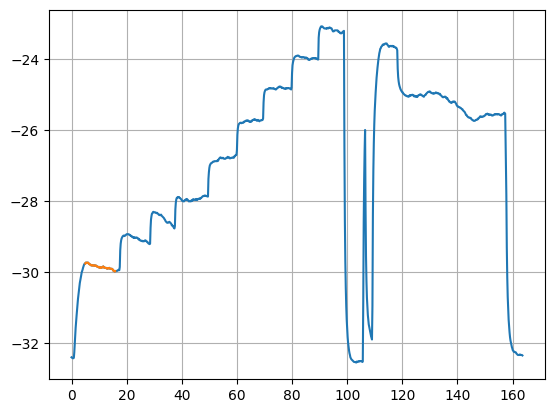

In [125]:
run = 85

t, T = query_sensor(run, "L1")

plt.plot(t, T)
plt.grid()
mask = (t > 5) & (t < 16)
plt.plot(t[mask], T[mask])
np.mean(T[mask])

{'TM1_L1': (0.6449999999999945, -29.66666666666662), 'TM2_L1': (0.9482857142857123, -30.62390476190474), 'TM2_L2': (0.7605714285714281, -30.72980952380951), 'TM2_L3': (0.7902857142857133, -31.209904761904745), 'TM2_L4': (0.7039999999999994, -31.20533333333333)}


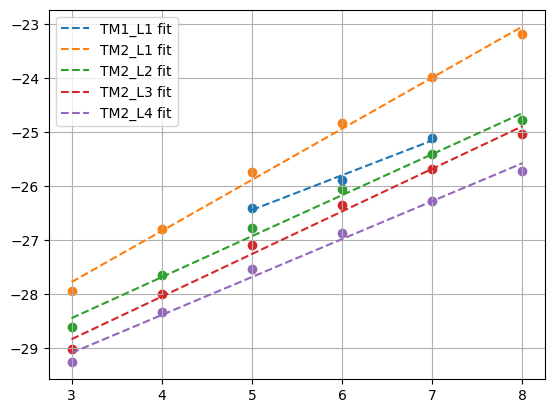

In [ ]:
power_vs_lgad = {
    "TM1_L1": [
        # W, LGAD Temperature
        (5, -26.40),
        (6, -25.88),
        (7, -25.11)
    ],
    # run 85
    "TM2_L1": [
        (3, -27.95),
        (4, -26.79),
        (5, -25.73),
        (6, -24.82),
        (7, -23.98),
        (8, -23.18)
    ],
    "TM2_L2": [
        (3, -28.62),        
        (4, -27.64),
        (5, -26.78),
        (6, -26.05),
        (7, -25.41),
        (8, -24.78)
    ],
    "TM2_L3": [
        (3, -29.02),       
        (4, -28.00),
        (5, -27.10),
        (6, -26.35),
        (7, -25.68),
        (8, -25.03)    ],
    "TM2_L4": [
        (3, -29.27),
        (4, -28.34),
        (5, -27.53),
        (6, -26.87),
        (7, -26.28),
        (8, -25.71)    ]
}

fits = {}
post_fits = {
    'TM1_L1': (0.6449999999999945, -29.66666666666662), 
    'TM2_L1': (0.9482857142857123, -30.62390476190474), 
    'TM2_L2': (0.7605714285714281, -30.72980952380951), 
    'TM2_L3': (0.7902857142857133, -31.209904761904745), 
    'TM2_L4': (0.7039999999999994, -31.20533333333333)
}

for name, power_temp_data in power_vs_lgad.items():
    powers = np.array([i[0] for i in power_temp_data])
    temps =  np.array([i[1] for i in power_temp_data])
    plt.scatter(powers, temps)

    # fitt
    m, b = np.polyfit(powers, temps, 1)  # Linear fit (degree 1)
    plt.plot(powers, m*powers + b, linestyle='--', label=f"{name} fit")

    fits[name] = (float(m),float(b))

plt.grid()
plt.legend()
print(fits)
